# CarND Vehicle Detection

In [39]:
import os
import glob
import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [40]:
#import content
veh_dir = 'vehicles/'

kinds = os.listdir(veh_dir)
print (kinds)
vehs = []
for im_type in kinds:
    vehs.extend(glob.glob(veh_dir+im_type+'/*'))
print (len(vehs))

['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']
8792


In [41]:
non_veh_dir = 'non-vehicles/'

kinds = os.listdir(non_veh_dir)
print (kinds)
non_vehs = []
for im_type in kinds:
    print (non_veh_dir+im_type)
    non_vehs.extend(glob.glob(non_veh_dir+im_type+'/*'))
print (len(non_vehs))

['all']
non-vehicles/all
8968


In [42]:
#make labels
with open('vehicles.txt', 'w') as v:
    for fn in vehs:
        v.write(fn+'\n')
with open('non-vehicles.txt', 'w') as n:
    for fn in non_vehs:
        n.write(fn+'\n')

In [82]:
# Define image processing helper functions
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32,32)):
    color1 = cv.resize(img[:,:,0], size).ravel()
    color2 = cv.resize(img[:,:,1], size).ravel()
    color3 = cv.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Plot a figure with all three bar charts
def plot_hist(hist_0, hist_1, hist_2):
    bin_edges = hist_0[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, hist_0[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, hist_1[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, hist_2[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')

def color_hist(img, nbins=32, plot=False):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    if (plot == True):
        plot_hist(channel1_hist, channel2_hist, channel3_hist)
    return hist_features

def color_swap(img, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            return cv.cvtColor(img, cv.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            return cv.cvtColor(img, cv.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            return cv.cvtColor(img, cv.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            return cv.cvtColor(img, cv.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            return cv.cvtColor(img, cv.COLOR_RGB2YCrCb)
    else: 
        return img


def extract_features(imgs, cspace='RGB', spatial_size=(32,32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spat_features=True, hist_features=True, hog_features=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = color_swap(image, cspace) 
            
        if spat_features==True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_features==True:
            histo_features= color_hist(feature_image, nbins=hist_bins, plot=False)
            file_features.append(histo_features)
        if hog_features==True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features_list = []
                for channel in range(feature_image.shape[2]):
                    hog_features_list.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features_list = np.ravel(hog_features_list)        
            else:
                hog_features_list = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features_list)
        # Return list of feature vectors
        features.append(np.concatenate(file_features))
    return features 

def extract_single_features(img, cspace='RGB', spatial_size=(32,32), hist_bins=32, orient=9, vis=False,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spat_features=True, hist_features=True, hog_features=True):
    # Create a list to append feature vectors to
    img_features = []
    # Iterate through the list of images
    # apply color conversion if other than 'RGB'
    feature_image = color_swap(img, cspace)

    if spat_features==True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_features==True:
        histo_features= color_hist(feature_image, nbins=hist_bins, plot=False)
        img_features.append(histo_features)
    if hog_features==True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features_list = []
            for channel in range(feature_image.shape[2]):
                hog_features_list.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features_list = np.ravel(hog_features_list)        
        else:
            if vis == True:
                hog_features_list, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features_list = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        img_features.append(hog_features_list)
    # Return list of feature vectors
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_single_features(test_img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spat_features=spatial_feat, 
                            hist_features=hist_feat, hog_features=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def visualize(fig,rows,cols,imgs,titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols, i+1)
        plt.title(i+1)
        img_dims = len(np.array(img.shape))
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img

In [83]:
### TRAINING
#color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL"# Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [None, None] # Min and max in y to search in slide_window()

t = time.time()
n_samples = 1000
random_idx = np.random.randint(0,len(vehs), n_samples)

test_v = np.array(vehs)[random_idx]
test_nv = np.array(non_vehs)[random_idx]

#car_img = mpimg.imread(test_v)
#not_car_img = mpimg.imread(test_nv)

cspaces= ['RGB', 'LUV', 'HSV', 'HLS', 'YUV', 'YCrCb' ]

#for x in range(len(cspaces)):
color_space = cspaces[5]
car_features = extract_features(test_v, cspace=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spat_features=spatial_feat, 
                        hist_features=hist_feat, hog_features=hog_feat)
notcar_features= extract_features(test_nv, cspace=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spat_features=spatial_feat, 
                        hist_features=hist_feat, hog_features=hog_feat)
#images = [car_img, car_hog_img, not_car_img, not_car_hog_img]
#titles = ['car img', color_space, 'not_car_img', color_space]
#fig = plt.figure(figsize=(6,9))
#visualize(fig, 1, 4, images, titles)


print(time.time()-t, 'Seconds to compute features ....')
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

9.274200201034546 Seconds to compute features ....
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
1.01 Seconds to train SVC...
Test Accuracy of SVC =  0.9775


0.0 1.0
0.28575849533081055 seconds to process one image searching 57 windows
0.0 1.0
0.2767360210418701 seconds to process one image searching 57 windows
0.0 1.0
0.28275227546691895 seconds to process one image searching 57 windows
0.0 1.0
0.2762339115142822 seconds to process one image searching 57 windows
0.0 1.0
0.27874135971069336 seconds to process one image searching 57 windows
0.0 1.0
0.27523183822631836 seconds to process one image searching 57 windows


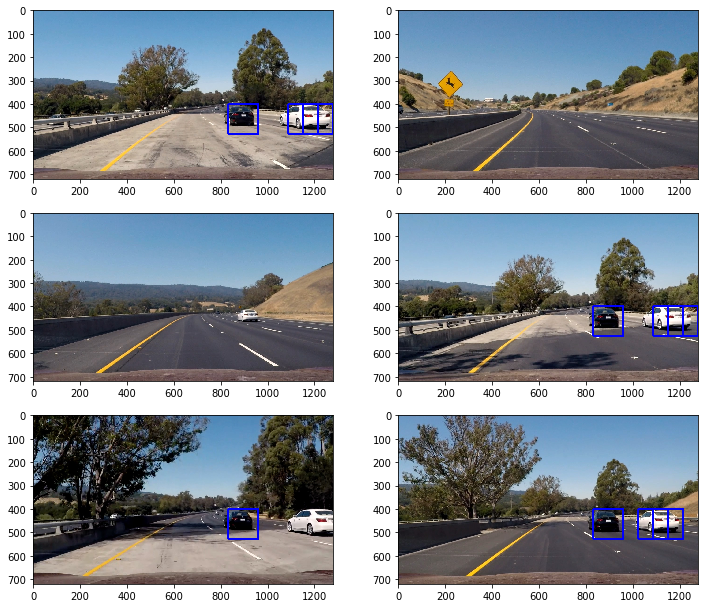

In [84]:
#TEST OUR BOUNDING BOXES SECTION
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images=[]
titles=[]
y_start_stop = [400, 656]
overlap = 0.5
for img_src in example_images:

    t1=time.time()

    img = mpimg.imread(img_src)
    draw_image = np.copy(img)

    # convert from png to jpg
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(overlap, overlap))

    #all the "hot" windows we think contain cars
    hot_windows = search_windows(img, windows, svc, X_scaler, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)        
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')
fig = plt.figure(figsize=(12,18))
visualize(fig, 5, 2, images, titles)

In [85]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv.cvtColor(img, cv.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv.cvtColor(img, cv.COLOR_BGR_2YCrCb)
    if conv == 'RGB2LUV':
        return cv.cvtColor(img, cv.COLOR_RGB2LUV)

C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

true
true
true
true
true
true
true
true
0.4326505661010742 seconds to run, total windows =  294


C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

0.4652371406555176 seconds to run, total windows =  294


C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

true
true
0.4513068199157715 seconds to run, total windows =  294


C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

true
true
true
true
true
true
true
true
true
true
true
true
0.6056118011474609 seconds to run, total windows =  294


C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

true
true
true
true
0.4376637935638428 seconds to run, total windows =  294


C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

true
true
true
true
true
true
true
true
true
true
true
0.44969630241394043 seconds to run, total windows =  294


C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\oakis\Anaconda3\envs\kerasEnv\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

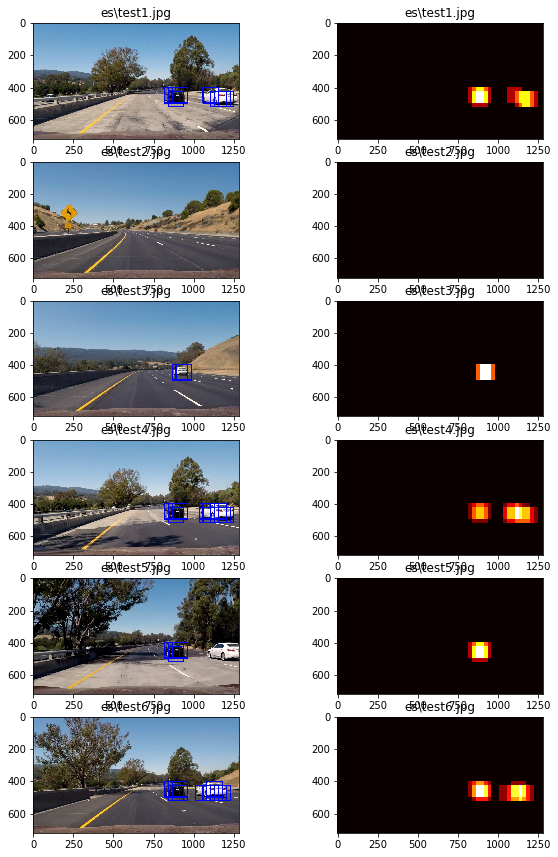

In [87]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
out_images = []
out_maps = []
out_boxes = []
out_titles = []
img_boxes = []
ystart = 400
ystop = 656
scale = 1.5

#def find_cars(img, scale):
for img_src in example_images:
    img_boxes = []
    count = 0
    t = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv.resize(ctrans_tosearch, (np.int(imshape[1]/scale),np.int(imshape[0]/scale)) )

    ch0 = ctrans_tosearch[:,:,0]
    ch1 = ctrans_tosearch[:,:,1]
    ch2 = ctrans_tosearch[:,:,2]

    nxblocks = (ch0.shape[1] // pix_per_cell) - 1
    nyblocks = (ch0.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog0 = get_hog_features(ch0, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            hog_feat0 = hog0[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat0, hog_feat1, hog_feat2))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            #extract the image patch
            subimg = cv.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            #features time
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, plot=False)

            #scale features
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features))).reshape(1,-1)
            test_prediction = svc.predict(test_features)

            #if prediction says true, draw a box and add it to the heatmap
            if test_prediction == 1:
                print ("true")
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0,0,255), 6)
                img_boxes.append(((xbox_left, ytop_draw+ystart ), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    print (time.time()-t, 'seconds to run, total windows = ', count)
    #return draw_img, heatmap
    out_images.append(draw_img)

    
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    out_images.append(heatmap)
    cv.imwrite("heatmap"+str(time.time())+".png", heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
%matplotlib inline     
fig = plt.figure(figsize=(10,20))
visualize(fig, 8, 2, out_images, out_titles)



# for img_src in example_images:
#     img = mpimg.imread(img_src)
#     find_cars(img, 1)

In [ ]:
from scipy.ndimage.measurements import label

def slide_multiple_windows(image, sizes = [64,96,128],x_start_stop=[None,None], y_start_stop=y_start_stop, xy_window=(64,64),overlap=(0.5, 0.5)):
    windows = []
    for size in sizes:
        window = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(size, size), xy_overlap=overlap)
        windows += window
    return windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
out_images = []
out_titles = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5
#iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    heat_map_thresh = apply_threshold(heat_map, 2)
    labels = label(heat_map_thresh)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_titles.append(img_src[-12:])
    out_images.append(draw_img)
    out_titles.append(img_src[-12:])
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualize(fig,8,2,out_images,out_titles)

In [17]:
def process_image(img):
    global heat
    global windows
    image = img.astype(np.float32)/255
    draw_image = np.copy(image)
    windows = slide_multiple_windows(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(64,64), overlap=(0.8, 0.8))
    hot_windows = search_windows(image, windows, svc, X_scaler, cspace=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 25, 255), thick=6)
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    heat_threshold = 2
    heatmap = add_heat(heat, hot_windows)
    heatmap = apply_threshold(heatmap, heat_threshold)
    labels = label(heatmap)
    applied_image = draw_labeled_bboxes(np.copy(img), labels)    
    return applied_image

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'output_tracked_final_ll.mp4'
input_video = 'lane_lines.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(process_image)
video_clip.write_videofile(output_video, audio=False)


MoviePy: building video file output_tracked_final_ll.mp4
----------------------------------------

Writing video into output_tracked_final_ll.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1210/1211 [3:48:56<00:10, 10.76s/it]  0%|                                                                               | 1/1211 [00:10<3:22:03, 10.02s/it]

100%|████████████████████████████████████████████████████████████████████████████| 1211/1211 [3:49:07<00:00, 10.79s/it]


Done writing video in output_tracked_final_ll.mp4 !
Your video is ready !
